In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

# Overfitting and underfitting

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

在上一章的三个例子（预测电影评论、主题分类和房价回归）中，模型在留出验证数据上的性能总是在几轮后达到最高点，然后开始下降。也就是说，模型很快就在训练数据上开始过拟合。过拟合存在于所有机器学习问题中。学会如何处理过拟合对掌握机器学习至关重要。

机器学习的根本问题是优化和泛化之间的对立。优化（optimization）是指调节模型以在训练数据上得到最佳性能（即机器学习中的学习），而泛化（generalization）是指训练好的模型在前所未见的数据上的性能好坏。机器学习的目的当然是得到良好的泛化，但你无法控制泛化，只能基于训练数据调节模型。

训练开始时，优化和泛化是相关的：训练数据上的损失越小，测试数据上的损失也越小。这时的模型是欠拟合（underfit）的，即仍有改进的空间，网络还没有对训练数据中所有相关模式建模。但在训练数据上迭代一定次数之后，泛化不再提高，验证指标先是不变，然后开始变差，即模型开始过拟合。这时模型开始学习仅和训练数据有关的模式，但这种模式对新数据来说是错误的或无关紧要的。

为了防止模型从训练数据中学到错误或无关紧要的模式，最优解决方法是获取更多的训练数据。模型的训练数据越多，泛化能力自然也越好。如果无法获取更多数据，次优解决方法是调节模型允许存储的信息量，或对模型允许存储的信息加以约束。如果一个网络只能记住几个模式，那么优化过程会迫使模型集中学习最重要的模式，这样更可能得到良好的泛化。

这种降低过拟合的方法叫作正则化（regularization）。我们先介绍几种最常见的正则化方法， 然后将其应用于实践中，以改进上一节的电影分类模型。

注意：在这个notebook中，我们将使用IMDB测试集作为我们的验证集。 在这种情况下关系不大。

让我们使用准备数据并使用第3章第5节中的代码：

In [2]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data[:5000])
# Our vectorized test data
x_test = vectorize_sequences(test_data[:2000])
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Fighting overfitting

## Reducing the network's size


防止过拟合的最简单的方法就是减小模型大小，即减少模型中可学习参数的个数（这由层 数和每层的单元个数决定）。在深度学习中，模型中可学习参数的个数通常被称为模型的容量（capacity）。直观上来看，参数更多的模型拥有更大的记忆容量（memorization capacity），因此能 够在训练样本和目标之间轻松地学会完美的字典式映射，这种映射没有任何泛化能力。例如，拥 有 500 000 个二进制参数的模型，能够轻松学会 MNIST 训练集中所有数字对应的类别——我们 只需让 50 000 个数字每个都对应 10 个二进制参数。但这种模型对于新数字样本的分类毫无用处。 始终牢记：深度学习模型通常都很擅长拟合训练数据，但真正的挑战在于泛化，而不是拟合。

与此相反，如果网络的记忆资源有限，则无法轻松学会这种映射。因此，为了让损失最小化，网络必须学会对目标具有很强预测能力的压缩表示，这也正是我们感兴趣的数据表示。同时请记住，你使用的模型应该具有足够多的参数，以防欠拟合，即模型应避免记忆资源不足。在容 量过大与容量不足之间要找到一个折中。

不幸的是，没有一个魔法公式能够确定最佳层数或每层的最佳大小。你必须评估一系列不 同的网络架构（当然是在验证集上评估，而不是在测试集上），以便为数据找到最佳的模型大小。 要找到合适的模型大小，一般的工作流程是开始时选择相对较少的层和参数，然后逐渐增加层的大小或增加新层，直到这种增加对验证损失的影响变得很小。

我们在电影评论分类的网络上试一下。原始网络如下所示。

In [3]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

In [5]:
y_train = y_train[:5000]
y_test = y_test[:2000]


Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [6]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=64,
                                   validation_data=(x_test, y_test))

Train on 5000 samples, validate on 2000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 273us/step - loss: 0.5023 - acc: 0.7842 - val_loss: 0.3664 - val_acc: 0.8620
Epoch 2/20
5000/5000 [==============================] - 1s 224us/step - loss: 0.2342 - acc: 0.9190 - val_loss: 0.4305 - val_acc: 0.8160
Epoch 3/20
5000/5000 [==============================] - 1s 216us/step - loss: 0.1319 - acc: 0.9602 - val_loss: 0.3619 - val_acc: 0.8590
Epoch 4/20
5000/5000 [==============================] - 1s 230us/step - loss: 0.0783 - acc: 0.9768 - val_loss: 0.3955 - val_acc: 0.8495
Epoch 5/20
5000/5000 [==============================] - 1s 221us/step - loss: 0.0430 - acc: 0.9904 - val_loss: 0.4520 - val_acc: 0.8480
Epoch 6/20
5000/5000 [==============================] - 1s 223us/step - loss: 0.0220 - acc: 0.9960 - val_loss: 0.6124 - val_acc: 0.8355
Epoch 7/20
5000/5000 [==============================] - 1s 224us/step - loss: 0.0095 - acc: 0.9982 - val_loss: 0.6246 - val_acc: 0.8405


In [7]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=64,
                                       validation_data=(x_test, y_test))

Train on 5000 samples, validate on 2000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 213us/step - loss: 0.6422 - acc: 0.6256 - val_loss: 0.5749 - val_acc: 0.6865
Epoch 2/20
5000/5000 [==============================] - 1s 204us/step - loss: 0.5210 - acc: 0.8000 - val_loss: 0.5054 - val_acc: 0.7980
Epoch 3/20
5000/5000 [==============================] - 1s 181us/step - loss: 0.4350 - acc: 0.8896 - val_loss: 0.4733 - val_acc: 0.8330
Epoch 4/20
5000/5000 [==============================] - 1s 190us/step - loss: 0.3772 - acc: 0.9390 - val_loss: 0.4609 - val_acc: 0.8405
Epoch 5/20
5000/5000 [==============================] - 1s 177us/step - loss: 0.3364 - acc: 0.9598 - val_loss: 0.4673 - val_acc: 0.8315
Epoch 6/20
5000/5000 [==============================] - 1s 203us/step - loss: 0.3041 - acc: 0.9724 - val_loss: 0.5355 - val_acc: 0.8140
Epoch 7/20
5000/5000 [==============================] - 1s 201us/step - loss: 0.2794 - acc: 0.9780 - val_loss: 0.6143 - val_acc: 0.8020


In [8]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

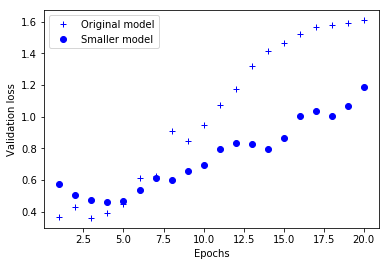

In [10]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


如你所见，更小的网络开始过拟合的时间要晚于参考网络（前者 6 轮后开始过拟合，而后者 4 轮后开始），而且开始过拟合之后，它的性能变差的速度也更慢。

现在，为了好玩，我们再向这个基准中添加一个容量更大的网络（容量远大于问题所需）。

In [11]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [12]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=64,
                                     validation_data=(x_test, y_test))

Train on 5000 samples, validate on 2000 samples
Epoch 1/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.4581 - acc: 0.7886 - val_loss: 0.7725 - val_acc: 0.6655
Epoch 2/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1365 - acc: 0.9524 - val_loss: 0.4173 - val_acc: 0.8495
Epoch 3/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0376 - acc: 0.9900 - val_loss: 0.5778 - val_acc: 0.8555
Epoch 4/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0138 - acc: 0.9968 - val_loss: 0.8949 - val_acc: 0.8485
Epoch 5/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0119 - acc: 0.9982 - val_loss: 0.9617 - val_acc: 0.8435
Epoch 6/20
5000/5000 [==============================] - 14s 3ms/step - loss: 5.4765e-05 - acc: 1.0000 - val_loss: 1.1726 - val_acc: 0.8435
Epoch 7/20
5000/5000 [==============================] - 14s 3ms/step - loss: 0.0124 - acc: 0.9976 - val_loss: 1.2490 - val_acc: 0.8445
Epo

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

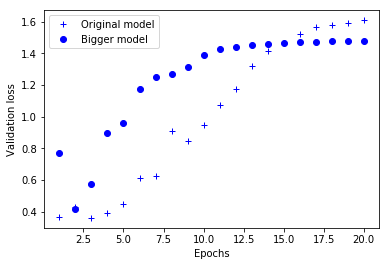

In [13]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

更大的网络只过了一轮就开始过拟合，过拟合也更严重。其验证损失的波动也更大。

下图同时给出了这两个网络的训练损失。

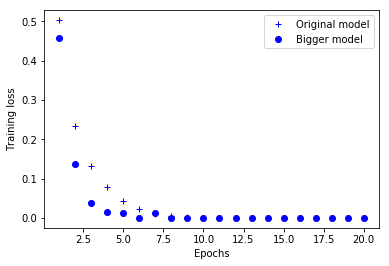

In [14]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

如你所见，更大网络的训练损失很快就接近于零。 网络的容量越大，它拟合训练数据（即得到很小的训练损失）的速度就越快，但也更容易过拟合（导致训练损失和验证损失有很大差异）。

## Adding weight regularization


你可能知道奥卡姆剃刀（Occam’s razor）原理：如果一件事情有两种解释，那么最可能正 确的解释就是最简单的那个，即假设更少的那个。这个原理也适用于神经网络学到的模型：给 定一些训练数据和一种网络架构，很多组权重值（即很多模型）都可以解释这些数据。简单模 型比复杂模型更不容易过拟合。

这里的简单模型（simple model）是指参数值分布的熵更小的模型（或参数更少的模型，比如上一节的例子）。因此，一种常见的降低过拟合的方法就是强制让模型权重只能取较小的值， 从而限制模型的复杂度，这使得权重值的分布更加规则（regular）。这种方法叫作权重正则化（weight regularization），其实现方法是向网络损失函数中添加与较大权重值相关的成本（cost）。 这个成本有两种形式。

* L1 正则化（L1 regularization）：添加的成本与权重系数的绝对值［权重的 L1 范数（norm）］ 成正比。
* L2 正则化（L2 regularization）：添加的成本与权重系数的平方（权重的 L2 范数）成正比。 神经网络的 L2 正则化也叫权重衰减（weight decay）。不要被不同的名称搞混，权重衰减 与 L2 正则化在数学上是完全相同的。

在 Keras 中，添加权重正则化的方法是向层传递 权重正则化项实例（weight regularizer instance）作为关键字参数。下列代码将向电影评论分类网络中添加 L2 权重正则化。

In [15]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l2(0.001) 的意思是该层权重矩阵的每个系数都会使网络总损失增加 0.001 * weight_coefficient_value。注意，由于这个惩罚项只在训练时添加，所以这个网络的训练损失会 比测试损失大很多。

下图显示了 L2 正则化惩罚的影响。

In [17]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=64,
                             validation_data=(x_test, y_test))

Train on 5000 samples, validate on 2000 samples
Epoch 1/20
5000/5000 [==============================] - 2s 306us/step - loss: 0.5309 - acc: 0.7932 - val_loss: 0.4165 - val_acc: 0.8560
Epoch 2/20
5000/5000 [==============================] - 1s 259us/step - loss: 0.2889 - acc: 0.9178 - val_loss: 0.3549 - val_acc: 0.8650
Epoch 3/20
5000/5000 [==============================] - 1s 274us/step - loss: 0.2056 - acc: 0.9478 - val_loss: 0.3709 - val_acc: 0.8550
Epoch 4/20
5000/5000 [==============================] - 1s 277us/step - loss: 0.1627 - acc: 0.9658 - val_loss: 0.3897 - val_acc: 0.8525
Epoch 5/20
5000/5000 [==============================] - 1s 287us/step - loss: 0.1375 - acc: 0.9716 - val_loss: 0.4578 - val_acc: 0.8375
Epoch 6/20
5000/5000 [==============================] - 1s 257us/step - loss: 0.1226 - acc: 0.9802 - val_loss: 0.4328 - val_acc: 0.8500
Epoch 7/20
5000/5000 [==============================] - 1s 258us/step - loss: 0.1096 - acc: 0.9830 - val_loss: 0.4837 - val_acc: 0.8380


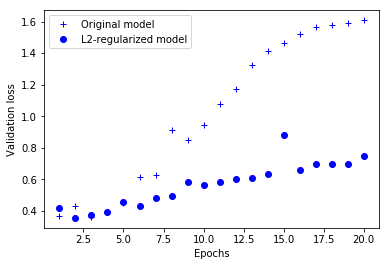

In [18]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


如你所见，即使两个模型的参数个数相同，具有 L2正则化的模型（圆点）比参考模型（十字）更不容易过拟合。

你还可以用 Keras 中以下这些权重正则化项来代替 L2 正则化。

In [19]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

## Adding dropout


dropout 是神经网络最有效也最常用的正则化方法之一，它是由多伦多大学的 Geoffrey Hinton和他的学生开发的。对某一层使用 dropout，就是在训练过程中随机将该层的一些输出特征舍弃（设置为 0）。假设在训练过程中，某一层对给定输入样本的返回值应该是向量 [0.2, 0.5, 1.3, 0.8, 1.1]。使用 dropout 后，这个向量会有几个随机的元素变成 0，比如 [0, 0.5,1.3, 0, 1.1]。dropout 比率（dropout rate）是被设为 0 的特征所占的比例，通常在 0.2~0.5 范围内。测试时没有单元被舍弃，而该层的输出值需要按 dropout 比率缩小，因为这时比训练时有更多的单元被激活，需要加以平衡。

假设有一个包含某层输出的 Numpy 矩阵 layer_output，其形状为 (batch_size, features)。训练时，我们随机将矩阵中一部分值设为 0。

In [20]:
# At training time: we drop out 50% of the units in the output
layer_output *= np.randint(0, high=2, size=layer_output.shape)

NameError: name 'layer_output' is not defined


测试时，我们将输出按 dropout 比率缩小。这里我们乘以 0.5（因为前面舍弃了一半的单元）。

In [ ]:
# At test time:
layer_output *= 0.5

注意，为了实现这一过程，还可以让两个运算都在训练时进行，而测试时输出保持不变。这通常也是实践中的实现方式：

In [ ]:
# At training time:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5

这一方法可能看起来有些奇怪和随意。它为什么能够降低过拟合？ Hinton 说他的灵感之一来自于银行的防欺诈机制。用他自己的话来说：“我去银行办理业务。柜员不停地换人，于是我问其中一人这是为什么。他说他不知道，但他们经常换来换去。我猜想，银行工作人员要想成功欺诈银行，他们之间要互相合作才行。这让我意识到，在每个样本中随机删除不同的部分神经元，可以阻止它们的阴谋，因此可以降低过拟合。”

其核心思想是在层的输出值中引入噪声， 打破不显著的偶然模式（Hinton 称之为阴谋）。如果没有噪声的话，网络将会记住这些偶然模式。

在 Keras 中，你可以通过 Dropout 层向网络中引入 dropout，dropout 将被应用于前面一层的输出。

In [21]:
model.add(layers.Dropout(0.5))

NameError: name 'model' is not defined

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [22]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [23]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=64,
                               validation_data=(x_test, y_test))

Train on 5000 samples, validate on 2000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 289us/step - loss: 0.6219 - acc: 0.6558 - val_loss: 0.4939 - val_acc: 0.8210
Epoch 2/20
5000/5000 [==============================] - 1s 250us/step - loss: 0.4671 - acc: 0.7970 - val_loss: 0.3844 - val_acc: 0.8635
Epoch 3/20
5000/5000 [==============================] - 1s 248us/step - loss: 0.3582 - acc: 0.8578 - val_loss: 0.3357 - val_acc: 0.8645
Epoch 4/20
5000/5000 [==============================] - 1s 253us/step - loss: 0.2824 - acc: 0.8972 - val_loss: 0.3327 - val_acc: 0.8625
Epoch 5/20
5000/5000 [==============================] - 2s 317us/step - loss: 0.2410 - acc: 0.9222 - val_loss: 0.3424 - val_acc: 0.8635
Epoch 6/20
5000/5000 [==============================] - 1s 267us/step - loss: 0.2058 - acc: 0.9334 - val_loss: 0.3661 - val_acc: 0.8650
Epoch 7/20
5000/5000 [==============================] - 1s 254us/step - loss: 0.1790 - acc: 0.9450 - val_loss: 0.3881 - val_acc: 0.8655


Let's plot the results:

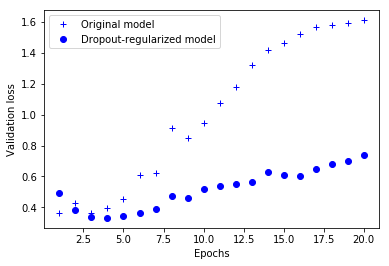

In [24]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


我们再次看到，这种方法的性能相比参考网络有明显提高。

总结一下，防止神经网络过拟合的常用方法包括：

* 获取更多的训练数据
* 减小网络容量
* 添加权重正则化
* 添加 dropout